# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

A: The data represents the latest marketing campain which involved getting potential clients to subscribe to a long term deposit application with what the bank considered a good interest rate.  Furthermore, there was some information retained from the previous campain for each person contacted, which included the previous compains success.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

#### Dataset Characteristics
- Data is imbalanced with regards to using the success vs failure class/column 'y': 
  - No  : 36548
  - Yes : 4640
- No NaN or empty feature/column values detected

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import time

In [3]:
# read raw banking data from CSV file
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

# rename feature columns to something more useful
df.columns = ['age', 'job_type', 'marital_status', 'education', 'credit_in_default', 'housing_loan', 'personal_loan', 'contact_method', 'month_last_contact', 'dayOfWeek_last_contact', 'contact_duration_seconds', 'contact_attempts_during_campaign', 'days_since_last_contact', 'contact_attempts_previous_camapain', 'outcome_previous_campain', 'employment_variation_rate_quarteryly', 'consumer_price_index_monthly', 'consumer_confidence_index_monthly', 'euribor3_monthly_rate_daily', 'number_employed_quarterly', 'subscribed']

In [4]:
# dataset balance of subscribed class (derived from column 'y').
df['subscribed'].value_counts()

subscribed
no     36548
yes     4640
Name: count, dtype: int64

In [5]:
# view data set
df.head(-10)

,age,job_type,marital_status,education,credit_in_default,housing_loan,personal_loan,contact_method,month_last_contact,dayOfWeek_last_contact,...,contact_attempts_during_campaign,days_since_last_contact,contact_attempts_previous_camapain,outcome_previous_campain,employment_variation_rate_quarteryly,consumer_price_index_monthly,consumer_confidence_index_monthly,euribor3_monthly_rate_daily,number_employed_quarterly,subscribed
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41173,62,retired,married,university.degree,no,yes,no,cellular,nov,thu,...,1,999,2,failure,-1.1,94.767,-50.8,1.031,4963.6,yes
41174,62,retired,married,university.degree,no,yes,no,cellular,nov,thu,...,1,1,6,success,-1.1,94.767,-50.8,1.031,4963.6,yes
41175,34,student,single,unknown,no,yes,no,cellular,nov,thu,...,1,999,2,failure,-1.1,94.767,-50.8,1.031,4963.6,no
41176,38,housemaid,divorced,high.school,no,yes,yes,cellular,nov,thu,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.031,4963.6,no


In [6]:
# view new feature/column names
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   age                                   41188 non-null  int64  
 1   job_type                              41188 non-null  object 
 2   marital_status                        41188 non-null  object 
 3   education                             41188 non-null  object 
 4   credit_in_default                     41188 non-null  object 
 5   housing_loan                          41188 non-null  object 
 6   personal_loan                         41188 non-null  object 
 7   contact_method                        41188 non-null  object 
 8   month_last_contact                    41188 non-null  object 
 9   dayOfWeek_last_contact                41188 non-null  object 
 10  contact_duration_seconds              41188 non-null  int64  
 11  contact_attempt

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - (Month of Contact) - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - (Call Duration) - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - (Number of Previous Contacts) - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - (Days Since Last Contact) - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - (Last Contact Results) - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```

The following Python code shall transform the columns using the OneHotEncoder.  Furthermore, any columns generated from data that equaled the value of 'unknown' shall be removed.

In [7]:
# get column names for numeric and catagorical features
categorical_columns = df.drop('subscribed', axis=1).select_dtypes(include=['object']).columns.tolist()
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# features that require OneHotEncoding
for category_name in categorical_columns :
    catagory_count = df[category_name].value_counts()
    print (catagory_count)
    print ('\n')



job_type
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64


marital_status
married     24928
single      11568
divorced     4612
unknown        80
Name: count, dtype: int64


education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64


credit_in_default
no         32588
unknown     8597
yes            3
Name: count, dtype: int64


housing_loan
yes        21576
no         18622
unknown      990
Name: count, dtype: int64


personal_loan
no         33950
yes         6248
unknown      990
Name: count, dtype: int64


contact_method
cellu

In [8]:
print('categorical columns: ', categorical_columns)

# create feature DataFrame
X = df.drop('subscribed', axis=1)

# encode columns with category data and remove unwanted columns
for category_name in categorical_columns :
    encoder = OneHotEncoder() # drop='first'...doing this manually

    # transform category data
    encoded_data = encoder.fit_transform(X[[category_name]])

    # Convert the encoded data to a DataFrame
    encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out([category_name]))

    # Drop OHE created: 'unknown' categorical column from DataFrame...this replaces drop='first' for OHE
    if category_name + '_unknown' in encoded_df.columns:
        encoded_df.drop([category_name + '_unknown'], axis=1, inplace=True)

    elif encoded_df.columns.size > 2: 
        # drop first column if 'unknown' column doesn't exist and there are more than two columns total, generated by OHE
        encoded_df.drop([encoded_df.columns[0]], axis=1, inplace=True) 

    print('remaining columns from encoder for category ['+ category_name +']: ', encoded_df.columns.tolist())

    # Concatenate the encoded DataFrame with the original DataFrame
    X = pd.concat([X, encoded_df], axis=1)

    # Drop original categorical column from DataFrame
    X.drop([category_name], axis=1, inplace=True)



categorical columns:  ['job_type', 'marital_status', 'education', 'credit_in_default', 'housing_loan', 'personal_loan', 'contact_method', 'month_last_contact', 'dayOfWeek_last_contact', 'outcome_previous_campain']
remaining columns from encoder for category [job_type]:  ['job_type_admin.', 'job_type_blue-collar', 'job_type_entrepreneur', 'job_type_housemaid', 'job_type_management', 'job_type_retired', 'job_type_self-employed', 'job_type_services', 'job_type_student', 'job_type_technician', 'job_type_unemployed']
remaining columns from encoder for category [marital_status]:  ['marital_status_divorced', 'marital_status_married', 'marital_status_single']
remaining columns from encoder for category [education]:  ['education_basic.4y', 'education_basic.6y', 'education_basic.9y', 'education_high.school', 'education_illiterate', 'education_professional.course', 'education_university.degree']
remaining columns from encoder for category [credit_in_default]:  ['credit_in_default_no', 'credit_in_

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

#### Business Objective:
The task at hand is to create a model that shall be used to predict if a potential customer shall subscribe to the banks product using the feature data provided from previous campains as well as the outcome from said campains as the target.  In the end, this model shall allow the business (bank) to target potential customer's more accurately.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [10]:
# OneHotEncoding performed in previous step so we only need a standard scaler

# create preprocessor using StandardScaler to encode all feature data which
# is now numeric
preprocessor = ColumnTransformer(
    transformers=[
        ('encoder', StandardScaler(), X.columns.tolist())
    ])

# extract target
y = df.subscribed

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [98]:
# the baseline models using default hyperparameters
models = {
    'knn': (KNeighborsClassifier()),
    'logisticregression': (LogisticRegression()),
    'svc': (SVC()),
    'decisiontreeclassifier': (DecisionTreeClassifier())
}


In [99]:
results = []

# Execute pipeline containing encoded data
# and target models
for name, (model) in models.items():
    # Create a pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        (name, model)
    ])
    
    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid={}, cv=5, n_jobs=-1)
    
    # Fit the model and time it
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    fit_time = (time.time() - start_time) / len(grid_search.cv_results_['mean_fit_time'])
    
    # Get the best estimator
    best_model = grid_search.best_estimator_
    print(grid_search.best_params_)
    print(grid_search.best_estimator_)
    
    # Evaluate on training and test sets
    train_score = best_model.score(X_train, y_train)
    test_score = best_model.score(X_test, y_test)
    
    # Append the results
    results.append([name, train_score, test_score, fit_time])

# Create the results DataFrame
results_df = pd.DataFrame(results, columns=['model', 'train score', 'test score', 'average fit time'])
results_df.set_index('model', inplace=True)

results_df.to_json('data/baseline_model_results.json')

{}
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('encoder', StandardScaler(),
                                                  ['age',
                                                   'contact_duration_seconds',
                                                   'contact_attempts_during_campaign',
                                                   'days_since_last_contact',
                                                   'contact_attempts_previous_camapain',
                                                   'employment_variation_rate_quarteryly',
                                                   'consumer_price_index_monthly',
                                                   'consumer_confidence_index_monthly',
                                                   'euribor3_monthly_ra...
                                                   'job_type_self-employed',
                                                   'job_type_services',
        

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [ ]:
#Logistic regregession was used to model data in previous step

### Problem 9: Score the Model

What is the accuracy of your model?

In [ ]:
# baseline accuracy for each model is as follows
results_df.loc[:, ['test score']]

,test score
model,
knn,0.896091
logisticregression,0.911265
svc,0.908230
decisiontreeclassifier,0.884802


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [105]:
baseline_df = pd.read_json(r'data/baseline_model_results.json')
baseline_df

,train score,test score,average fit time
knn,0.920759,0.896091,7.258002
logisticregression,0.911806,0.911265,3.113580
svc,0.926555,0.908230,44.530929
decisiontreeclassifier,1.000000,0.884802,3.167607


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [ ]:
# Logistic Regression - feature selection using L1 as penalty

# create list of best coefficients
# Cs = np.logspace(-5, .5)
# Cs
Cs = [1.00000000e-05, 8.09400122e-04, 2.27584593e-03, 6.55128557e-02, 5.17947468e-01, 3.16227766e+00]
    #        , 1.29492584e-05, 1.67683294e-05, 2.17137430e-05,
    #    2.81176870e-05, 3.64103195e-05, 4.71486636e-05, 6.10540230e-05,
    #    7.90604321e-05, 1.02377397e-04, 1.32571137e-04, 1.71669791e-04,
    #    2.22299648e-04, 2.87861559e-04, 3.72759372e-04, 4.82695744e-04,
    #    6.25055193e-04, 8.09400122e-04, 1.04811313e-03, 1.35722878e-03,
    #    1.75751062e-03, 2.27584593e-03, 2.94705170e-03, 3.81621341e-03,
    #    4.94171336e-03, 6.39915234e-03, 8.28642773e-03, 1.07303094e-02,
    #    1.38949549e-02, 1.79929362e-02, 2.32995181e-02, 3.01711481e-02,
    #    3.90693994e-02, 5.05919749e-02, 6.55128557e-02, 8.48342898e-02,
    #    1.09854114e-01, 1.42252931e-01, 1.84206997e-01, 2.38534401e-01,
    #    3.08884360e-01, 3.99982340e-01, 5.17947468e-01, 6.70703561e-01,
    #    8.68511374e-01, 1.12465782e+00, 1.45634848e+00, 1.88586328e+00,
    #    2.44205309e+00, 3.16227766e+00

coef_list = []
for C in Cs:
    lr = LogisticRegression(penalty='l1', solver='liblinear', C=C, random_state=42, max_iter=1000).fit(X_train, y_train)
    coef_list.append(list(lr.coef_[0]))

coef_df = pd.DataFrame(coef_list, columns=X_train.columns)
coef_df.index = Cs
coef_df


,age,contact_duration_seconds,contact_attempts_during_campaign,days_since_last_contact,contact_attempts_previous_camapain,employment_variation_rate_quarteryly,consumer_price_index_monthly,consumer_confidence_index_monthly,euribor3_monthly_rate_daily,number_employed_quarterly,...,month_last_contact_may,month_last_contact_nov,month_last_contact_oct,month_last_contact_sep,dayOfWeek_last_contact_mon,dayOfWeek_last_contact_thu,dayOfWeek_last_contact_tue,dayOfWeek_last_contact_wed,outcome_previous_campain_nonexistent,outcome_previous_campain_success
0.000010,0.000000,0.003341,0.000000,-0.002553,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000160,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.002276,0.002611,0.004280,-0.002332,-0.001883,0.000000,0.000000,0.018877,0.042546,-0.525216,-0.000067,...,-0.101594,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.065513,0.000224,0.004591,-0.050540,-0.001818,-0.083217,-0.540330,0.407446,0.012099,0.134847,-0.007897,...,-0.777935,-0.329331,0.000000,-0.017381,-0.116550,0.000000,0.040399,0.061220,0.320436,0.000000
0.517947,0.000224,0.004644,-0.051014,-0.001138,-0.038868,-0.917402,0.560838,-0.005178,0.590992,-0.011270,...,-0.675187,-0.545385,-0.022460,-0.194112,-0.105760,0.079433,0.106130,0.145883,0.420854,0.752199
3.162278,0.000501,0.004641,-0.051920,-0.001062,-0.009599,-0.768655,0.470012,0.000467,0.398316,-0.009486,...,-0.692182,-0.465509,0.050719,-0.153209,-0.097571,0.088346,0.120733,0.159441,0.458334,0.847519


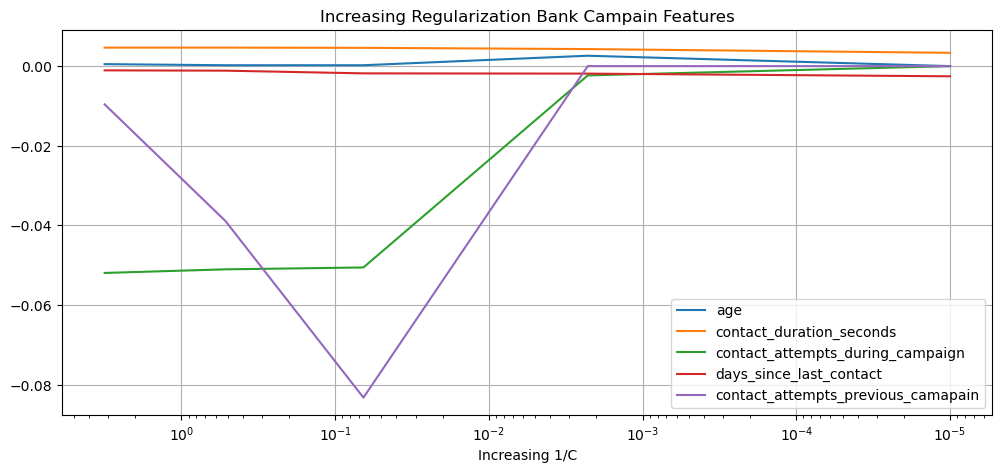

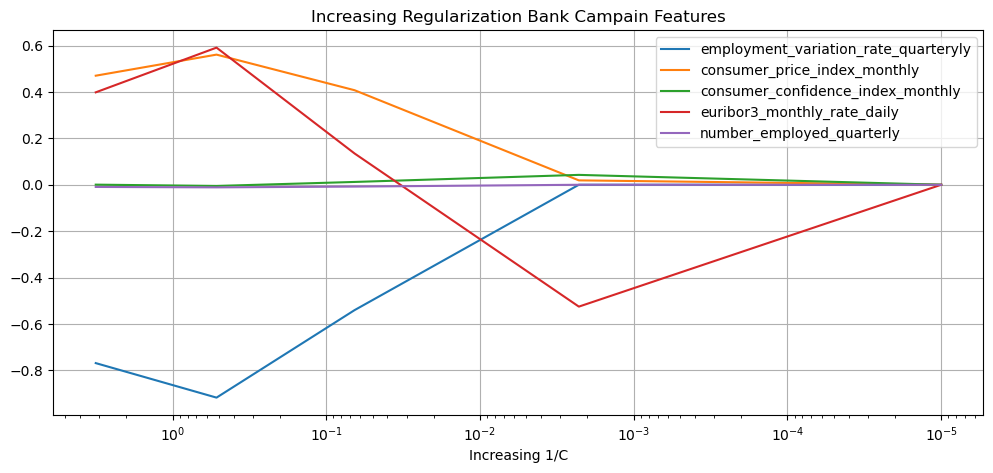

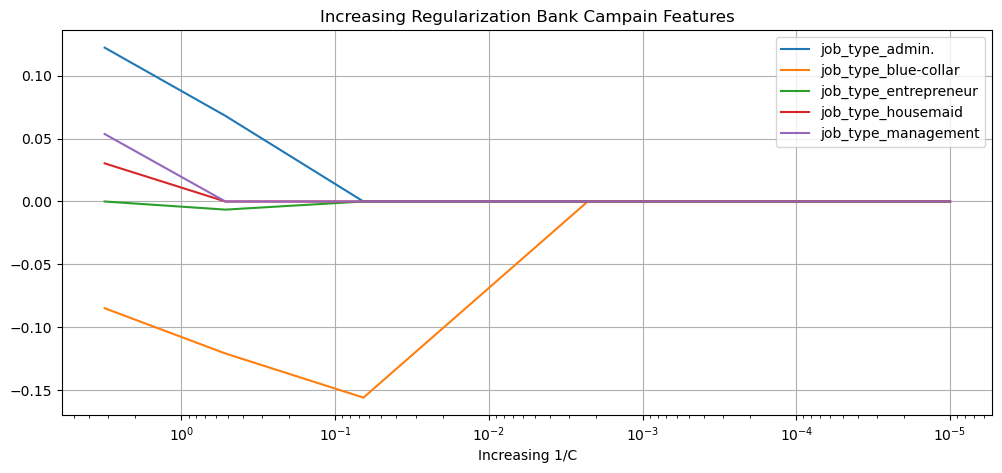

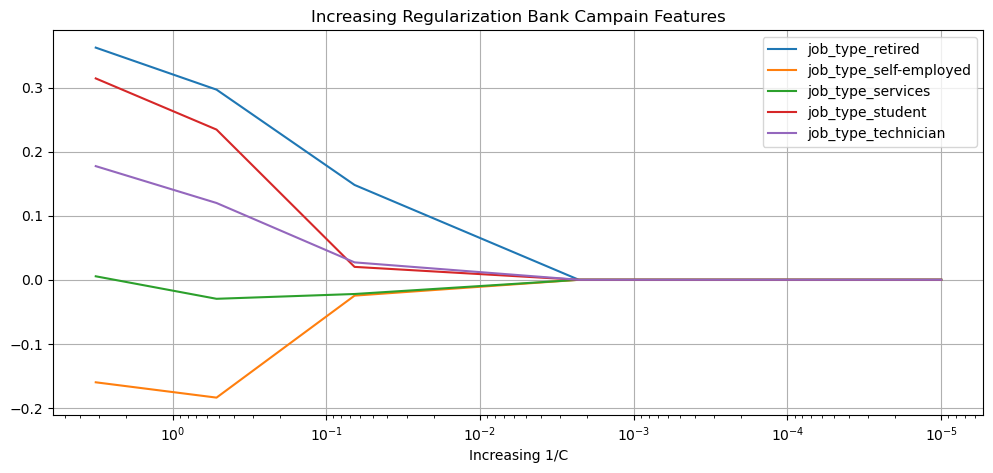

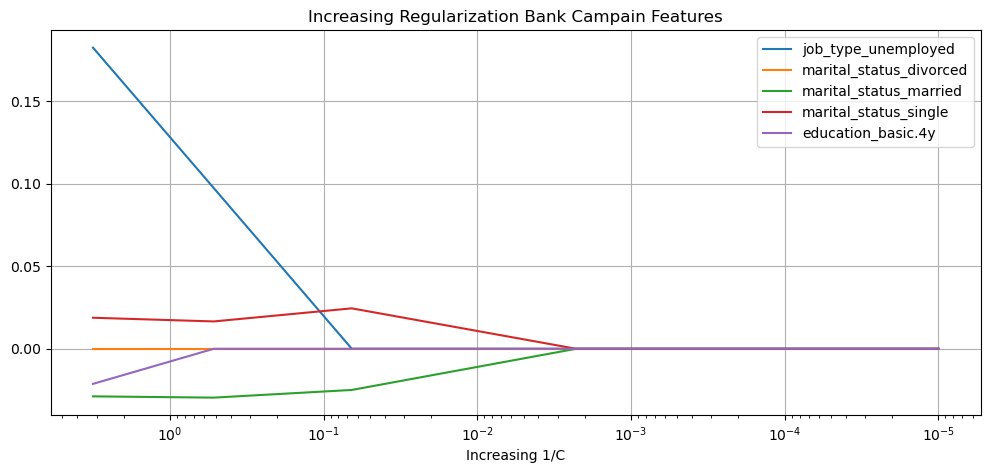

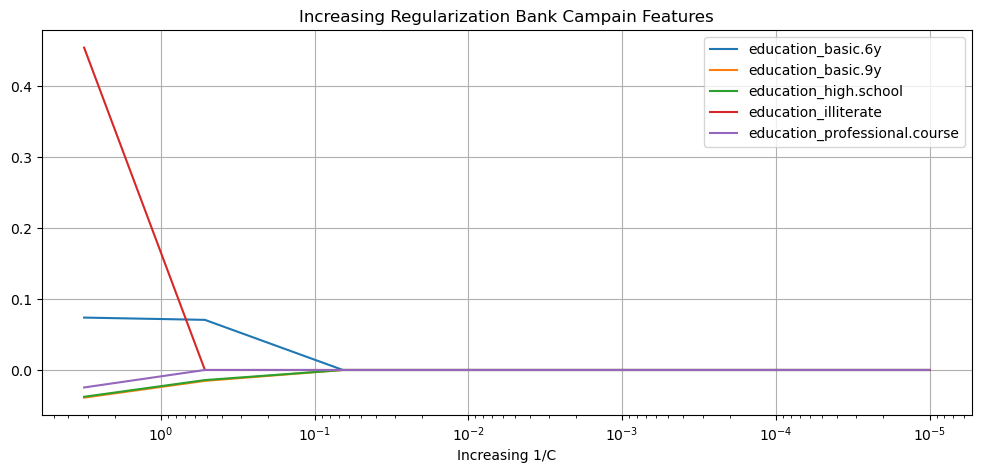

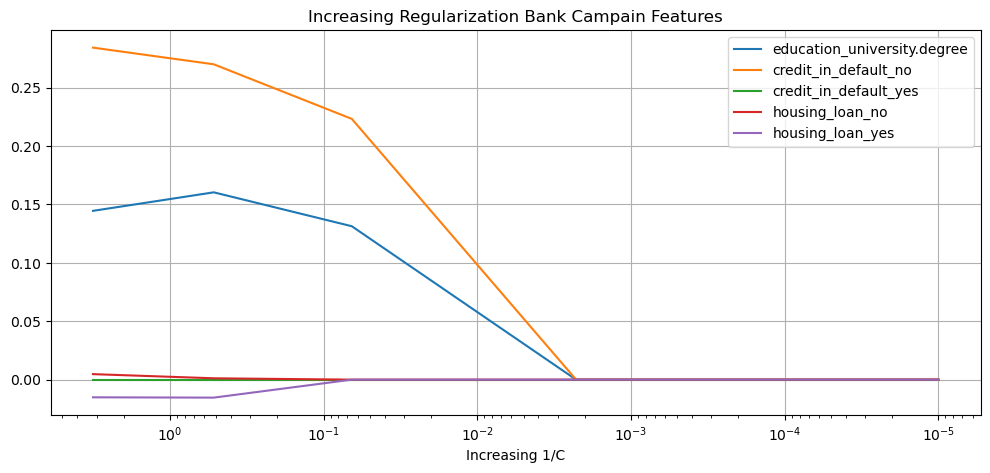

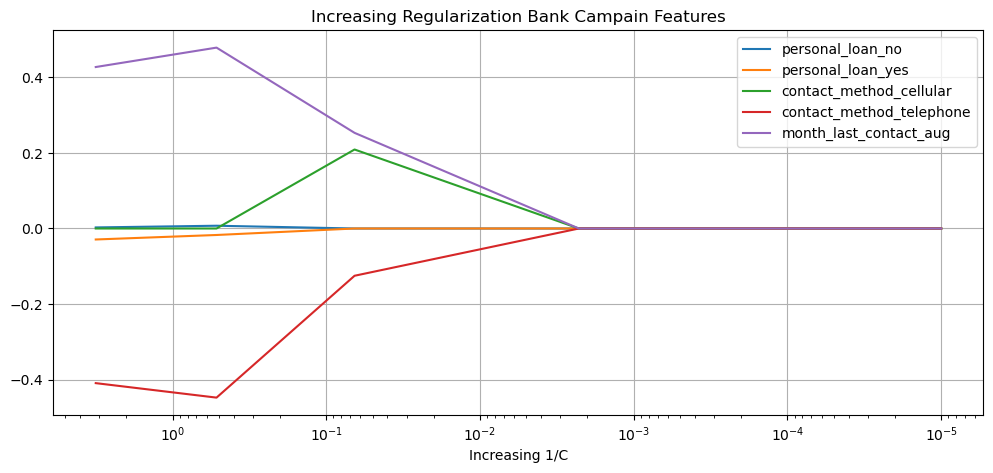

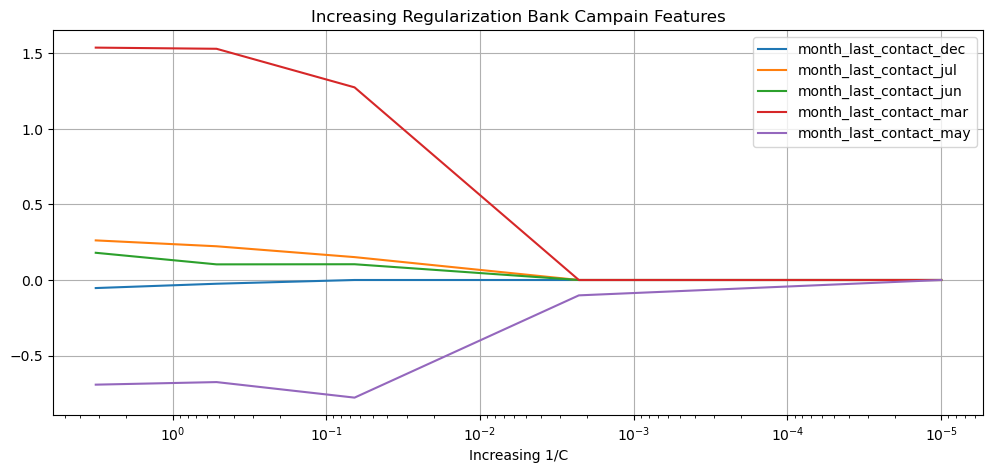

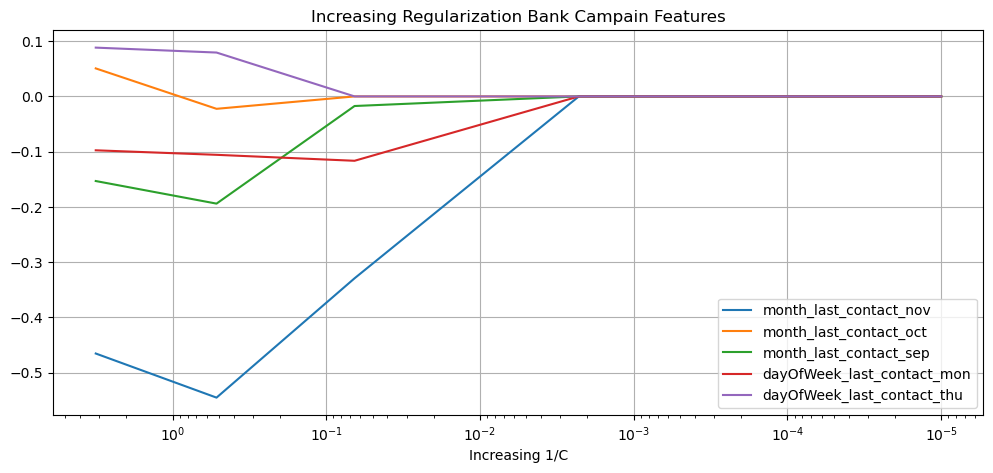

In [18]:
features_list = coef_df.columns.to_list()
features_list

# display the best features

column_list = []
for idx in range(len(features_list)) :
    column_list.append(features_list[idx])

    if len(column_list) == 5 :
        plt.figure(figsize = (12, 5))
        plt.semilogx(coef_df.loc[:, column_list])
        plt.gca().invert_xaxis()
        plt.grid()
        plt.legend(column_list);
        plt.title('Increasing Regularization Bank Campain Features')
        plt.xlabel("Increasing 1/C")
        plt.savefig('images/best_lr_features_using_coef_l1_' + str(idx) + '.png')

        column_list = []


In [ ]:
Cs = [1.00000000e-05, 8.09400122e-04, 2.27584593e-03, 6.55128557e-02, 5.17947468e-01, 3.16227766e+00]

for C in Cs:
    selector = SelectFromModel(LogisticRegression(C=C, penalty='l1', solver='liblinear', max_iter=10000, random_state=42))
    ans = selector.fit_transform(X_train, y_train)
    print(selector.get_feature_names_out())  # get best feature names that converged


['contact_duration_seconds' 'days_since_last_contact'
 'number_employed_quarterly']
['age' 'contact_duration_seconds' 'days_since_last_contact'
 'consumer_price_index_monthly' 'consumer_confidence_index_monthly'
 'euribor3_monthly_rate_daily' 'number_employed_quarterly']
['age' 'contact_duration_seconds' 'contact_attempts_during_campaign'
 'days_since_last_contact' 'consumer_price_index_monthly'
 'consumer_confidence_index_monthly' 'euribor3_monthly_rate_daily'
 'number_employed_quarterly' 'month_last_contact_may']


##### Questions